In [21]:
# =========================================
# Cell 1: Imports and Initial Setup
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Used for train/val split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # Needed for Attention softmax
from torch.utils.data import DataLoader, TensorDataset
import os
import warnings
import copy # For saving best model state

# Optional: SMOTE for class balancing
try:
    from imblearn.over_sampling import SMOTE
    imblearn_available = True
except ImportError:
    print("Warning: imbalanced-learn library not found. SMOTE balancing will be skipped.")
    print("Install it using: pip install imbalanced-learn")
    imblearn_available = False

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Install it using: pip install imbalanced-learn


In [22]:
# =========================================
# Cell 2: Load Data and Initial View
# =========================================
print("Starting data loading process...")
# <<< --- IMPORTANT: SET YOUR FILE PATH HERE --- >>>
file_path = r"C:\Users\User\Downloads\UMHackathon2025\data\merged_btc_price_flow_data.csv"
# <<< --- IMPORTANT: SET YOUR FILE PATH HERE --- >>>

try:
    df = pd.read_csv(file_path)
    print(f"Original data shape: {df.shape}")
    print("\nFirst 5 rows of original data:")
    print(df.head())
    print("\nData Info:")
    df.info()
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable in the cell above.")
    raise


Starting data loading process...
Original data shape: (2433121, 13)

First 5 rows of original data:
             Timestamp     Open     High      Low    Close     Volume  \
0  2020-04-09 00:00:00  7311.27  7328.04  7311.27  7328.04   7.907567   
1  2020-04-09 00:01:00  7324.97  7332.48  7323.85  7326.89   5.357228   
2  2020-04-09 00:02:00  7329.96  7347.66  7329.96  7342.84  14.179910   
3  2020-04-09 00:03:00  7342.84  7347.68  7339.99  7345.00   5.050320   
4  2020-04-09 00:04:00  7347.59  7347.60  7334.80  7338.53   0.607997   

                    datetime  start_time  blockheight  flow_mean  flow_total  \
0  2020-04-09 00:00:00+00:00         NaN          NaN        NaN         NaN   
1  2020-04-09 00:01:00+00:00         NaN          NaN        NaN         NaN   
2  2020-04-09 00:02:00+00:00         NaN          NaN        NaN         NaN   
3  2020-04-09 00:03:00+00:00         NaN          NaN        NaN         NaN   
4  2020-04-09 00:04:00+00:00         NaN          NaN        

In [23]:
# =========================================
# Cell 3: Data Reduction
# =========================================
num_rows_to_keep = 2000000
if len(df) > num_rows_to_keep:
    print(f"Reducing dataset to the last {num_rows_to_keep} rows.")
    df = df.iloc[-num_rows_to_keep:]
    print(f"Reduced data shape: {df.shape}")
else:
    print("Dataset size is within the limit, no reduction needed.")

Reducing dataset to the last 2000000 rows.
Reduced data shape: (2000000, 13)


In [24]:
# =========================================
# Cell 4: Timestamp Conversion and Indexing
# =========================================
print("Converting timestamp and setting index...")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True) # Ensure data is chronologically sorted
print("Timestamp converted and set as index.")


Converting timestamp and setting index...
Timestamp converted and set as index.


In [25]:
# =========================================
# Cell 5: Data Cleaning
# =========================================
print("Cleaning the data...")
# Convert relevant columns to numeric
for col in df.columns:
    if col in ['datetime']: continue
    if not pd.api.types.is_numeric_dtype(df[col]):
         try:
             df[col] = pd.to_numeric(df[col], errors='coerce')
             # print(f"Converted column '{col}' to numeric.")
         except Exception as e:
             print(f"Could not convert column {col} to numeric: {e}")

# Fill NaN values in flow features
flow_cols = ['start_time', 'blockheight', 'flow_mean', 'flow_total', 'transactions_count_flow', 'regime']
existing_flow_cols = [col for col in flow_cols if col in df.columns]
print(f"Forward filling NaNs in columns: {existing_flow_cols}")
df[existing_flow_cols] = df[existing_flow_cols].fillna(method='ffill')
df[existing_flow_cols] = df[existing_flow_cols].fillna(0)

# Check for NaNs after initial cleaning (more checks after feature eng.)
print("\nNaN count by column after initial cleaning (showing columns with NaNs):")
nan_check = df.isna().sum()
print(nan_check[nan_check > 0])

Cleaning the data...
Forward filling NaNs in columns: ['start_time', 'blockheight', 'flow_mean', 'flow_total', 'transactions_count_flow', 'regime']

NaN count by column after initial cleaning (showing columns with NaNs):
Series([], dtype: int64)


In [31]:
import pandas as pd
import numpy as np

def calculate_rsi(series, window=14):
    """Calculate Relative Strength Index (RSI) without using pandas_ta."""
    print(f"Calculating RSI with window={window}...")
    delta = series.diff()
    
    # Make two series: one for gains, one for losses
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    
    # First value is sum of avg gains
    avg_gain = up.rolling(window).mean()
    avg_loss = down.rolling(window).mean()
    
    # Calculate RS ratio
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_bollinger_bands(series, window=20, nb_std=2):
    """Calculate Bollinger Bands without using pandas_ta."""
    print(f"Calculating Bollinger Bands with window={window}, std={nb_std}...")
    
    # Calculate middle band (SMA)
    middle_band = series.rolling(window=window).mean()
    
    # Calculate standard deviation
    std_dev = series.rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = middle_band + (std_dev * nb_std)
    lower_band = middle_band - (std_dev * nb_std)
    
    return upper_band, middle_band, lower_band

def calculate_stochastic(high, low, close, k_window=14, d_window=3):
    """Calculate Stochastic Oscillator (%K and %D) without using pandas_ta."""
    print(f"Calculating Stochastic Oscillator k={k_window}, d={d_window}...")
    
    # Calculate %K
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    
    # Handle division by zero
    denominator = highest_high - lowest_low
    denominator = denominator.replace(0, np.nan)
    
    k = 100 * ((close - lowest_low) / denominator)
    
    # Calculate %D (SMA of %K)
    d = k.rolling(window=d_window).mean()
    
    return k, d

def calculate_atr(high, low, close, window=14):
    """Calculate Average True Range (ATR) without using pandas_ta."""
    print(f"Calculating ATR with window={window}...")
    
    # Create True Range series
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    
    # True Range is the max of the three
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Calculate ATR as rolling average of True Range
    atr = tr.rolling(window=window).mean()
    
    return atr

def add_multi_timeframe_features(df):
    """Add features from different timeframes."""
    print("Adding multi-timeframe features...")
    
    # Ensure 'Close' column exists
    if 'Close' not in df.columns:
        print("Error: 'Close' column not found in DataFrame")
        return df
    
    # Medium timeframe features
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['RSI25'] = calculate_rsi(df['Close'], window=25)
    
    # Long timeframe features
    df['MA200'] = df['Close'].rolling(window=200).mean()
    
    # Trend direction indicator
    df['Trend_Direction'] = np.where(df['MA50'] > df['MA200'], 1, 
                                    np.where(df['MA50'] < df['MA200'], -1, 0))
    
    # Cross-timeframe metrics if available
    if 'MA5' in df.columns and 'MA20' in df.columns:
        df['MA_Cross'] = np.where(df['MA5'] > df['MA20'], 1, -1)
        df['MA_Cross_Change'] = df['MA_Cross'].diff()
    else:
        print("Warning: 'MA5' or 'MA20' not found, setting MA_Cross and MA_Cross_Change to default values")
        df['MA_Cross'] = 0
        df['MA_Cross_Change'] = 0.0
    
    return df

def calculate_volatility(df, window=20):
    """Calculate price volatility as standard deviation of returns."""
    returns = df['Close'].pct_change()
    volatility = returns.rolling(window=window).std()
    return volatility

# Function to identify market regimes
def identify_market_regimes(df, volatility_window=20, threshold_quantile=0.7):
    """Identify market regimes based on volatility."""
    print("Identifying market regimes...")
    
    # Calculate volatility
    df['Volatility'] = calculate_volatility(df, window=volatility_window)
    
    # Determine threshold using quantile
    volatility_threshold = df['Volatility'].quantile(threshold_quantile)
    
    # Assign market regime
    df['Market_Regime'] = np.where(df['Volatility'] > volatility_threshold, 'high_vol', 'low_vol')
    
    print(f"Volatility threshold: {volatility_threshold:.6f}")
    high_vol_pct = (df['Market_Regime'] == 'high_vol').mean() * 100
    print(f"High volatility periods: {high_vol_pct:.2f}%")
    
    return df

# Add enhanced price features
def add_enhanced_price_features(df):
    """Add enhanced price-based features."""
    print("Adding enhanced price features...")
    
    # Price momentum
    df['Price_Momentum_1d'] = df['Close'].pct_change(periods=1)
    df['Price_Momentum_5d'] = df['Close'].pct_change(periods=5)
    df['Price_Momentum_10d'] = df['Close'].pct_change(periods=10)
    
    # Price acceleration
    df['Price_Accel'] = df['Price_Momentum_1d'].diff()
    
    # High-Low range relative to close
    df['HL_Range_Ratio'] = (df['High'] - df['Low']) / df['Close']
    
    # Volume-weighted price
    df['Vol_Weighted_Price'] = df['Close'] * df['Volume'] / df['Volume'].rolling(5).mean()
    
    # Log returns instead of percentage
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    return df

# Add volume-based features
def add_volume_features(df):
    """Add enhanced volume-based features."""
    print("Adding volume features...")
    
    # Volume momentum
    df['Volume_Momentum_1d'] = df['Volume'].pct_change(periods=1)
    df['Volume_Momentum_5d'] = df['Volume'].pct_change(periods=5)
    
    # Volume moving averages
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    
    # Volume/MA ratio
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA20']
    
    # On-balance volume (OBV)
    obv = pd.Series(0, index=df.index)
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] - df['Volume'].iloc[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]
    df['OBV'] = obv
    
    # Money Flow Index components
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    raw_money_flow = typical_price * df['Volume']
    
    # Positive and Negative Money Flow
    positive_flow = pd.Series(0, index=df.index)
    negative_flow = pd.Series(0, index=df.index)
    
    for i in range(1, len(df)):
        if typical_price.iloc[i] > typical_price.iloc[i-1]:
            positive_flow.iloc[i] = raw_money_flow.iloc[i]
            negative_flow.iloc[i] = 0
        elif typical_price.iloc[i] < typical_price.iloc[i-1]:
            positive_flow.iloc[i] = 0
            negative_flow.iloc[i] = raw_money_flow.iloc[i]
        else:
            positive_flow.iloc[i] = 0
            negative_flow.iloc[i] = 0
    
    df['Positive_Flow'] = positive_flow
    df['Negative_Flow'] = negative_flow
    
    return df

print("Custom technical indicators implementation loaded successfully!")

Custom technical indicators implementation loaded successfully!


In [32]:
# =========================================
# Cell 6: Feature Engineering (Extended)
# =========================================
print("Performing extended feature engineering...")

# 1. Original Price-based features
df['Returns'] = df['Close'].pct_change()
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 2. Add New Technical Indicators (Using Placeholders from Cell 5.5)
print("Calculating additional technical indicators...")
df['RSI'] = calculate_rsi(df['Close'], window=14)
df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'], window=20)
df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle'].replace(0, np.nan) # Avoid division by zero
df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df['High'], df['Low'], df['Close'], k_window=14, d_window=3)
df['ATR'] = calculate_atr(df['High'], df['Low'], df['Close'], window=14) # Volatility measure for dynamic thresholds

# 3. Add Multi-Timeframe Features
df = add_multi_timeframe_features(df)

# 4. On-chain metrics normalization
if 'flow_mean' in df.columns:
    print("Normalizing 'flow_mean'...")
    rolling_mean = df['flow_mean'].rolling(100, min_periods=1).mean()
    rolling_std = df['flow_mean'].rolling(100, min_periods=1).std()
    df['flow_mean_normalized'] = (df['flow_mean'] - rolling_mean) / rolling_std.replace(0, np.nan)

# 5. Volume metrics
print("Calculating volume metrics...")
df['Volume_Change'] = df['Volume'].pct_change()
volume_ma20 = df['Volume'].rolling(20, min_periods=1).mean()
df['Volume_MA_Ratio'] = df['Volume'] / volume_ma20.replace(0, np.nan)

# 6. Price/Volume relationship
df['Price_Volume_Ratio'] = df['Close'] * df['Volume']

# 7. Target Variable (Needs to be last before NaN handling)
df['Target_Return'] = df['Returns'].shift(-1)
df['Target_Direction'] = np.where(df['Target_Return'] > 0, 1, 0)

print("Extended feature engineering complete.")
print(f"Number of columns after feature engineering: {len(df.columns)}")

Performing extended feature engineering...
Calculating additional technical indicators...
Calculating RSI with window=14...
Calculating Bollinger Bands with window=20, std=2...
Calculating Stochastic Oscillator k=14, d=3...
Calculating ATR with window=14...
Adding multi-timeframe features...
Calculating RSI with window=25...
Normalizing 'flow_mean'...
Calculating volume metrics...
Extended feature engineering complete.
Number of columns after feature engineering: 39


In [33]:
# =========================================
# Cell 7: Final NaN Handling
# =========================================
print("Filling remaining NaN values after feature engineering...")
# Replace infinite values that might arise from calculations (e.g., division by zero)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

initial_nan_count = df.isna().sum().sum()
print(f"NaN count before final filling: {initial_nan_count}")

# Use ffill first (most common for time series)
df.fillna(method='ffill', inplace=True)
# Use bfill to fill any NaNs at the very beginning
df.fillna(method='bfill', inplace=True)
# As a final safeguard, fill any remaining NaNs with 0 (shouldn't be many after ffill/bfill)
df.fillna(0, inplace=True)

# Drop the very last row which will have NaN for the shifted 'Target_Return' and 'Target_Direction'
# Although fillna(0) might have filled Target_Direction, dropping the last row is safer.
# Also ensures any leading rows completely filled by bfill (if initial data was short) are kept if valid
initial_rows = len(df)
df.dropna(subset=['Target_Return'], inplace=True) # Drop based on the shifted return being NaN

final_rows = len(df)
print(f"Dropped {initial_rows - final_rows} rows (primarily the last row with NaN target).")

print(f"\nData shape after all preprocessing: {df.shape}")
final_nan_count = df.isna().sum().sum()
if final_nan_count > 0:
     print(f"\nError: {final_nan_count} NaNs still remain after final filling!")
     print(df.isna().sum()[df.isna().sum() > 0])
else:
     print("\nConfirmed: No NaNs remain in the DataFrame.")

Filling remaining NaN values after feature engineering...
NaN count before final filling: 54766
Dropped 0 rows (primarily the last row with NaN target).

Data shape after all preprocessing: (2000000, 39)

Confirmed: No NaNs remain in the DataFrame.


In [34]:
# =========================================
# Cell 8: Feature Selection (Extended)
# =========================================
# Start with a base set
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Returns', 'MA5', 'MA20', 'MACD', 'MACD_Signal'
]

# Add flow columns if they exist
print("Checking for flow columns...")
flow_features_to_add = ['flow_mean', 'flow_total', 'transactions_count_flow', 'regime', 'flow_mean_normalized']
for col in flow_features_to_add:
    if col in df.columns:
        if col not in feature_columns: feature_columns.append(col)
        print(f" - Included '{col}'")

# Add new technical and volume features
print("Checking for new technical/volume features...")
new_features = [
    'RSI', 'BB_Width', 'Stoch_K', 'Stoch_D', 'ATR', # Base Tech Indicators
    'MA50', 'RSI25', 'MA200', 'Trend_Direction', 'MA_Cross', 'MA_Cross_Change', # Multi-Timeframe
    'Volume_Change', 'Volume_MA_Ratio', 'Price_Volume_Ratio' # Volume / Interaction
]
for col in new_features:
     if col in df.columns:
        if col not in feature_columns: feature_columns.append(col)
        print(f" - Included '{col}'")
     else:
        print(f" - Warning: Feature '{col}' not found, skipping.")


# Final check for existence and NaNs within selected features AFTER NaN handling
print("\nFinal check on selected feature columns...")
valid_feature_columns = []
for col in feature_columns:
    if col not in df.columns:
        print(f"Warning: Column '{col}' selected but not found in final DataFrame. Removing.")
    elif df[col].isna().any():
        print(f"Error: Column '{col}' still contains NaN values after processing. Removing.")
    else:
        valid_feature_columns.append(col)

feature_columns = valid_feature_columns # Use only valid columns

print(f"\nFinal features being used ({len(feature_columns)}): {feature_columns}")
if not feature_columns:
    raise ValueError("No valid feature columns remaining after checks!")

Checking for flow columns...
 - Included 'flow_mean'
 - Included 'flow_total'
 - Included 'transactions_count_flow'
 - Included 'regime'
 - Included 'flow_mean_normalized'
Checking for new technical/volume features...
 - Included 'RSI'
 - Included 'BB_Width'
 - Included 'Stoch_K'
 - Included 'Stoch_D'
 - Included 'ATR'
 - Included 'MA50'
 - Included 'RSI25'
 - Included 'MA200'
 - Included 'Trend_Direction'
 - Included 'MA_Cross'
 - Included 'MA_Cross_Change'
 - Included 'Volume_Change'
 - Included 'Volume_MA_Ratio'
 - Included 'Price_Volume_Ratio'

Final check on selected feature columns...

Final features being used (29): ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA5', 'MA20', 'MACD', 'MACD_Signal', 'flow_mean', 'flow_total', 'transactions_count_flow', 'regime', 'flow_mean_normalized', 'RSI', 'BB_Width', 'Stoch_K', 'Stoch_D', 'ATR', 'MA50', 'RSI25', 'MA200', 'Trend_Direction', 'MA_Cross', 'MA_Cross_Change', 'Volume_Change', 'Volume_MA_Ratio', 'Price_Volume_Ratio']


In [35]:
# =========================================
# Cell 9: Prepare X, y and Scale Features
# =========================================
X = df[feature_columns].values
y = df['Target_Direction'].values

print("X (features) shape:", X.shape)
print("y (target) shape:", y.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X_scaled shape:", X_scaled.shape)
print("Scaling complete.")

X (features) shape: (2000000, 29)
y (target) shape: (2000000,)
X_scaled shape: (2000000, 29)
Scaling complete.


In [36]:
# =========================================
# Cell 10: Train/Validation/Test Split (Chronological)
# =========================================
initial_train_size = int(len(X_scaled) * 0.8)
test_size = len(X_scaled) - initial_train_size
X_initial_train, X_test = X_scaled[:initial_train_size], X_scaled[initial_train_size:]
y_initial_train, y_test = y[:initial_train_size], y[initial_train_size:]

validation_split_ratio = 0.2
final_train_size = int(len(X_initial_train) * (1 - validation_split_ratio))
val_size = len(X_initial_train) - final_train_size
X_train, X_val = X_initial_train[:final_train_size], X_initial_train[final_train_size:]
y_train, y_val = y_initial_train[:final_train_size], y_initial_train[final_train_size:]

print(f"Total data points: {len(X_scaled)}")
print(f"Final Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Testing set size: {len(X_test)} samples")
assert len(X_train) + len(X_val) + len(X_test) == len(X_scaled), "Split sizes error!"

Total data points: 2000000
Final Training set size: 1280000 samples
Validation set size: 320000 samples
Testing set size: 400000 samples


In [37]:
# =========================================
# Cell 11: Sequence Creation Function (Unchanged)
# =========================================
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    # Handle case where input length is less than time_steps
    if not Xs:
        # Return empty arrays with correct dimensions if possible
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, time_steps, n_features)), np.empty((0,))
    return np.array(Xs), np.array(ys)

In [38]:
# =========================================
# Cell 12: Apply Sequence Creation
# =========================================
time_steps = 10 # Define the lookback period

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Validation sequences shape: {X_val_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

if X_train_seq.shape[0] == 0: raise ValueError("Training sequence set is empty.")
if X_val_seq.shape[0] == 0: print("\nWarning: Validation sequence set is empty.")

input_size = X_train_seq.shape[2]
print(f"\nInput size (number of features) for LSTM: {input_size}")

Training sequences shape: (1279990, 10, 29)
Validation sequences shape: (319990, 10, 29)
Testing sequences shape: (399990, 10, 29)

Input size (number of features) for LSTM: 29


In [39]:
# =========================================
# Cell 13.5: Apply SMOTE for Class Balancing (Optional)
# =========================================
apply_smote = True # <-- Set to True to enable SMOTE balancing

if apply_smote and imblearn_available and X_train_seq.shape[0] > 0:
    print("\nApplying SMOTE to balance training data...")
    n_samples, n_timesteps, n_features = X_train_seq.shape
    X_train_flat = X_train_seq.reshape(n_samples, n_timesteps * n_features)
    y_train_flat = y_train_seq

    print(f"Original training data shape: {X_train_flat.shape}")
    print(f"Original class distribution: {np.bincount(y_train_flat.astype(int))}")

    smote = SMOTE(random_state=42, k_neighbors=min(5, n_samples - 1)) # Adjust k_neighbors if samples are few
    try:
        X_train_balanced_flat, y_train_balanced = smote.fit_resample(X_train_flat, y_train_flat)

        print(f"Balanced training data shape: {X_train_balanced_flat.shape}")
        print(f"Balanced class distribution: {np.bincount(y_train_balanced.astype(int))}")

        X_train_balanced_seq = X_train_balanced_flat.reshape(-1, n_timesteps, n_features) # Use -1 for samples dim

        # Update sequence variables for DataLoader creation
        X_train_seq_final = X_train_balanced_seq
        y_train_seq_final = y_train_balanced
        print("SMOTE applied.")
        use_balanced_data = True
    except ValueError as e:
        print(f"SMOTE failed: {e}. Using original data.")
        X_train_seq_final = X_train_seq
        y_train_seq_final = y_train_seq
        use_balanced_data = False

else:
    if not imblearn_available and apply_smote: print("\nSkipping SMOTE: imblearn not installed.")
    elif not apply_smote: print("\nSkipping SMOTE: apply_smote is False.")
    elif X_train_seq.shape[0] == 0: print("\nSkipping SMOTE: No training data.")
    X_train_seq_final = X_train_seq
    y_train_seq_final = y_train_seq
    use_balanced_data = False




Skipping SMOTE: imblearn not installed.


In [40]:
# =========================================
# Cell 13: Convert to PyTorch Tensors
# =========================================
# Use the final (potentially balanced) training sequences
X_train_tensor = torch.FloatTensor(X_train_seq_final)
y_train_tensor = torch.FloatTensor(y_train_seq_final).unsqueeze(1)

X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1)

print("\nTensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")
print(f"X_val_tensor: {X_val_tensor.shape}")
print(f"y_val_tensor: {y_val_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}")
print(f"y_test_tensor: {y_test_tensor.shape}")


Tensor shapes:
X_train_tensor: torch.Size([1279990, 10, 29])
y_train_tensor: torch.Size([1279990, 1])
X_val_tensor: torch.Size([319990, 10, 29])
y_val_tensor: torch.Size([319990, 1])
X_test_tensor: torch.Size([399990, 10, 29])
y_test_tensor: torch.Size([399990, 1])


In [41]:
# =========================================
# Cell 14: Create DataLoaders
# =========================================
batch_size = 256

# Training DataLoader (uses balanced data if SMOTE was applied)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation DataLoader
if X_val_seq.shape[0] > 0:
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
else:
    val_loader = None

# Testing DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch size: {batch_size}")
print(f"Using {'balanced' if use_balanced_data else 'original'} training data.")


DataLoaders created with batch size: 256
Using original training data.


In [42]:
# =========================================
# Cell 15: Improved LSTM Model Definition (Bidirectional & Attention)
# =========================================
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.3):
        super(ImprovedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0,
                            bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid() # Keep Sigmoid for BCELoss

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        output, _ = self.lstm(x, (h0, c0))
        attn_weights = F.softmax(self.attention(output), dim=1)
        context_vector = torch.sum(attn_weights * output, dim=1)
        context_vector = self.bn(context_vector)
        out = self.fc1(context_vector)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

print("ImprovedLSTMModel class defined.")

ImprovedLSTMModel class defined.


In [43]:
# =========================================
# Cell 16: Initialize Model, Loss, Optimizer, Scheduler
# =========================================
# Hyperparameters
hidden_size = 64
num_layers = 2
output_size = 1
dropout_prob = 0.3
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
print("\nModel Architecture (Improved):")
print(model)

criterion = nn.BCELoss() # Use standard BCELoss with model's Sigmoid
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"\nLoss: {criterion}, Optimizer: Adam(lr={learning_rate}), Scheduler: ReduceLROnPlateau")

Using device: cpu

Model Architecture (Improved):
ImprovedLSTMModel(
  (lstm): LSTM(29, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Loss: BCELoss(), Optimizer: Adam(lr=0.001), Scheduler: ReduceLROnPlateau


In [44]:
# =========================================
# Cell 17/18: Updated Training Function
# =========================================

def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=5, max_grad_norm=1.0):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    early_stop_triggered = False

    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm) # Grad Clipping
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        epoch_train_loss = running_loss / total_samples if total_samples > 0 else 0
        epoch_train_acc = correct_predictions / total_samples if total_samples > 0 else 0
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        epoch_val_loss, epoch_val_acc = None, None
        if val_loader:
            model.eval()
            val_running_loss, val_correct_predictions, val_total_samples = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item() * inputs.size(0)
                    predicted = (outputs > 0.5).float()
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)
            if val_total_samples > 0:
                epoch_val_loss = val_running_loss / val_total_samples
                epoch_val_acc = val_correct_predictions / val_total_samples
                val_losses.append(epoch_val_loss)
                val_accuracies.append(epoch_val_acc)
                print(f'Epoch [{epoch+1}/{num_epochs}] Train L/A: {epoch_train_loss:.4f}/{epoch_train_acc:.4f} | Val L/A: {epoch_val_loss:.4f}/{epoch_val_acc:.4f}')
                scheduler.step(epoch_val_loss) # LR Scheduler Step
                if epoch_val_loss < best_val_loss:
                    best_val_loss = epoch_val_loss
                    epochs_no_improve = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    # print(f'  >> Val loss improved to {best_val_loss:.4f}. Saving state.')
                else:
                    epochs_no_improve += 1
                    # print(f'  >> Val loss did not improve for {epochs_no_improve} epoch(s).')
                if epochs_no_improve >= patience:
                    print(f'\nEarly stopping triggered after epoch {epoch + 1}!')
                    early_stop_triggered = True; break
            else: # val_loader exists but is empty
                print(f'Epoch [{epoch+1}/{num_epochs}] Train L/A: {epoch_train_loss:.4f}/{epoch_train_acc:.4f} | Val set empty.')
                val_losses.append(None); val_accuracies.append(None)
                # scheduler.step(epoch_train_loss) # Optionally step on train loss
        else: # No validation loader
             print(f'Epoch [{epoch+1}/{num_epochs}] Train L/A: {epoch_train_loss:.4f}/{epoch_train_acc:.4f} | No validation set.')
             scheduler.step(epoch_train_loss) # Step on train loss if no validation
             best_model_state = copy.deepcopy(model.state_dict()) # Save last state

    if not early_stop_triggered: print(f'\nTraining finished after {num_epochs} epochs.')
    if best_model_state is None and not early_stop_triggered: best_model_state = model.state_dict() # Save last if never improved

    print("--- Training Finished ---")
    actual_epochs = len(train_losses)
    return (train_losses, train_accuracies, val_losses[:actual_epochs], val_accuracies[:actual_epochs], best_model_state)

# Define the original evaluate_model for final testing (no changes needed here usually)
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    all_preds, all_labels = [], []
    test_loss, correct_predictions, total_samples = 0.0, 0, 0
    print("\n--- Starting Final Evaluation on TEST SET ---")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    if total_samples > 0:
        avg_test_loss = test_loss / total_samples
        accuracy = correct_predictions / total_samples
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        all_labels_flat = np.array(all_labels).flatten(); all_preds_flat = np.array(all_preds).flatten()
        print("\nClassification Report (Test Set):"); print(classification_report(all_labels_flat, all_preds_flat, zero_division=0))
        print("\nConfusion Matrix (Test Set):"); print(confusion_matrix(all_labels_flat, all_preds_flat))
        print("--- Test Set Evaluation Finished ---")
        return all_preds_flat, all_labels_flat, accuracy
    else: print("Test set is empty."); return [], [], 0.0

print("Updated training and evaluation functions defined.")


Updated training and evaluation functions defined.


In [49]:
# =========================================
# Cell 19: Train the Model
# =========================================
num_epochs = 50 # Max epochs
patience = 9    # Early stopping patience (increased slightly)
max_grad_norm = 1.0

# Ensure loaders and scheduler are defined
if 'train_loader' not in locals(): raise NameError("train_loader not defined.")
if 'val_loader' not in locals(): print("Warning: val_loader not defined. Validation and Early Stopping based on validation loss will be skipped.")
if 'scheduler' not in locals(): raise NameError("scheduler not defined.")

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, best_model_state = train_model_with_validation(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs, device, patience, max_grad_norm
)

# Handle cases where best_model_state might be None
if best_model_state is None:
     print("\nWarning: best_model_state is None after training. Using final model state.")
     best_model_state = model.state_dict() # Fallback to the final state


--- Starting Training ---
Epoch [1/50] Train L/A: 0.6867/0.5368 | Val L/A: 0.6808/0.5595
Epoch [2/50] Train L/A: 0.6864/0.5376 | Val L/A: 0.6801/0.5600
Epoch [3/50] Train L/A: 0.6863/0.5378 | Val L/A: 0.6805/0.5608
Epoch [4/50] Train L/A: 0.6862/0.5380 | Val L/A: 0.6800/0.5609
Epoch [5/50] Train L/A: 0.6862/0.5389 | Val L/A: 0.6802/0.5606
Epoch [6/50] Train L/A: 0.6861/0.5391 | Val L/A: 0.6804/0.5599
Epoch [7/50] Train L/A: 0.6860/0.5394 | Val L/A: 0.6803/0.5611
Epoch [8/50] Train L/A: 0.6859/0.5399 | Val L/A: 0.6805/0.5607
Epoch [9/50] Train L/A: 0.6857/0.5406 | Val L/A: 0.6804/0.5604
Epoch [10/50] Train L/A: 0.6856/0.5409 | Val L/A: 0.6804/0.5608
Epoch [11/50] Train L/A: 0.6856/0.5407 | Val L/A: 0.6808/0.5610
Epoch [12/50] Train L/A: 0.6855/0.5415 | Val L/A: 0.6805/0.5604
Epoch [13/50] Train L/A: 0.6854/0.5415 | Val L/A: 0.6806/0.5604

Early stopping triggered after epoch 13!
--- Training Finished ---



Training/Validation curves plot saved to training_validation_curves_improved.png


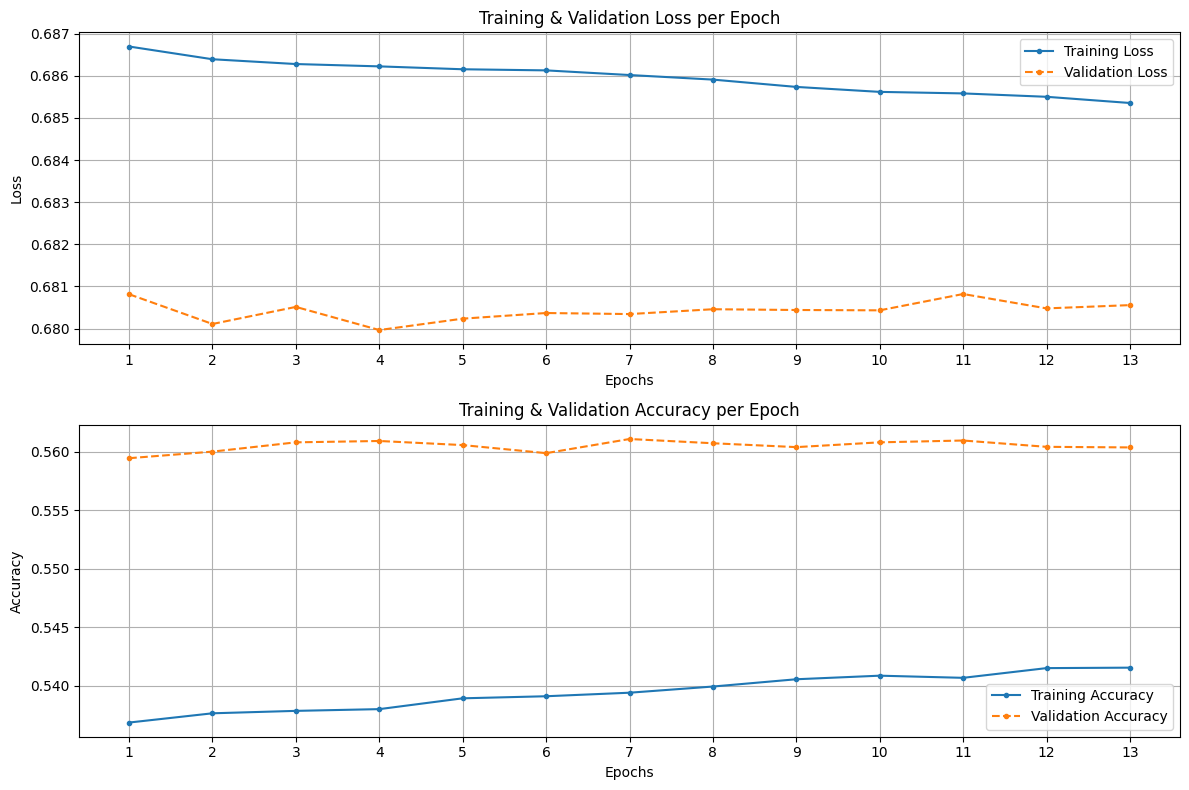

In [50]:
# =========================================
# Cell 20: Plot Training & Validation Curves
# =========================================
epochs_trained = len(train_losses)
if epochs_trained > 0: # Check if training actually ran
    plt.figure(figsize=(12, 8))
    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses, label='Training Loss', marker='.')
    if val_losses and any(v is not None for v in val_losses): # Check if validation loss list is not empty and contains values
        plt.plot(range(1, epochs_trained + 1), [v for v in val_losses if v is not None], label='Validation Loss', linestyle='--', marker='.')
    plt.title('Training & Validation Loss per Epoch')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.xticks(range(1, epochs_trained + 1))

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies, label='Training Accuracy', marker='.')
    if val_accuracies and any(v is not None for v in val_accuracies):
        plt.plot(range(1, epochs_trained + 1), [v for v in val_accuracies if v is not None], label='Validation Accuracy', linestyle='--', marker='.')
    plt.title('Training & Validation Accuracy per Epoch')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.xticks(range(1, epochs_trained + 1))

    plt.tight_layout()
    plot_filename = 'training_validation_curves_improved.png'
    plt.savefig(plot_filename)
    print(f"\nTraining/Validation curves plot saved to {plot_filename}")
    plt.show()
else:
    print("Skipping plotting as no training epochs were completed.")


In [51]:
# =========================================
# Cell 21: Evaluate the BEST Model on Test Set
# =========================================
if best_model_state:
    print("\nLoading best model state for final test evaluation...")
    model.load_state_dict(best_model_state)
    # Evaluate the loaded model
    y_pred_test, y_true_test, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    if test_accuracy is not None:
        test_accuracy_percentage = test_accuracy * 100
        print(f"\nFinal Test Accuracy (using best model): {test_accuracy_percentage:.2f}%")
    else:
        test_accuracy_percentage = 0; print("\nCould not calculate final test accuracy.")
else:
    print("\nError: No best model state available to evaluate.")
    test_accuracy_percentage = 0


Loading best model state for final test evaluation...

--- Starting Final Evaluation on TEST SET ---
Test Loss: 0.6922, Test Accuracy: 0.5251

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.53      0.92      0.67    209713
         1.0       0.50      0.09      0.15    190277

    accuracy                           0.53    399990
   macro avg       0.52      0.50      0.41    399990
weighted avg       0.52      0.53      0.42    399990


Confusion Matrix (Test Set):
[[193624  16089]
 [173865  16412]]
--- Test Set Evaluation Finished ---

Final Test Accuracy (using best model): 52.51%


In [52]:
# =========================================
# Cell 22: Save the BEST Model
# =========================================
model_save_path = 'bitcoin_lstm_best_model_improved.pth'
print(f"\nSaving BEST model state dictionary to {model_save_path}...")
if best_model_state:
    torch.save(best_model_state, model_save_path)
    print("Best model saved successfully.")
else:
    print("Warning: No best model state found to save.")


Saving BEST model state dictionary to bitcoin_lstm_best_model_improved.pth...
Best model saved successfully.


In [53]:
# =========================================
# Cell 23: Probability Generation Function (Unchanged)
# =========================================
def get_probabilities(model, data_loader, device):
    model.eval()
    probabilities = []
    print("\nGenerating prediction probabilities...")
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            # Handle case where dataloader might return a single batch result not as list
            if outputs.dim() == 0: # If scalar tensor
                 probabilities.append(outputs.cpu().item())
            else:
                 probabilities.extend(outputs.cpu().numpy())
    print("Probability generation complete.")
    return np.array(probabilities)


In [54]:
# =========================================
# Cell 24: Position Generation Function (Fixed Threshold - Fallback)
# =========================================
def get_positions(probabilities, threshold_buy=0.6, threshold_sell=0.4):
    if not (0 < threshold_sell < threshold_buy < 1):
        raise ValueError("Fixed thresholds error.")
    positions = np.zeros(len(probabilities))
    positions[probabilities > threshold_buy] = 1
    positions[probabilities < threshold_sell] = -1
    print(f"Fixed positions generated using thresholds: Buy > {threshold_buy}, Sell < {threshold_sell}")
    return positions

In [55]:
# =========================================
# Cell 24.5: Dynamic Threshold & Stop Loss Functions (Defined Earlier)
# =========================================
# Functions dynamic_signal_thresholds and implement_stop_loss were defined in Cell 24.5 previously
# Make sure that cell (or this one if moved) is executed before use.

# Re-defining here for clarity if Cell 24.5 wasn't created
def dynamic_signal_thresholds(probabilities, volatility_values, base_threshold_buy=0.55, base_threshold_sell=0.45, volatility_factor=0.1):
    if len(probabilities) != len(volatility_values):
        # Try to align if off by a small amount (e.g., sequence creation edge case)
        min_len = min(len(probabilities), len(volatility_values))
        print(f"Warning: Length mismatch in dynamic thresholds. Prob: {len(probabilities)}, Vol: {len(volatility_values)}. Using first {min_len} values.")
        probabilities = probabilities[:min_len]
        volatility_values = volatility_values[:min_len]
        # raise ValueError(f"Length mismatch: probabilities ({len(probabilities)}) vs volatility ({len(volatility_values)})")

    volatility_values = np.maximum(volatility_values, 0) # Ensure non-negative
    # Normalize volatility? Optional, depends on ATR scale. Let's assume ATR is somewhat stable scale.
    # Example normalization (0-1 range approx): vol_norm = (volatility_values - np.min(volatility_values)) / (np.max(volatility_values) - np.min(volatility_values) + 1e-6)

    thresholds_buy = base_threshold_buy + volatility_values * volatility_factor
    thresholds_sell = base_threshold_sell - volatility_values * volatility_factor
    thresholds_buy = np.clip(thresholds_buy, 0.501, 0.95)
    thresholds_sell = np.clip(thresholds_sell, 0.05, 0.499)

    positions = np.zeros(len(probabilities))
    for i in range(len(probabilities)):
        if probabilities[i] > thresholds_buy[i]: positions[i] = 1
        elif probabilities[i] < thresholds_sell[i]: positions[i] = -1
    print(f"Dynamic positions generated.")
    return positions

def implement_stop_loss(positions, prices, stop_percent=0.02):
    print(f"Applying stop loss simulation with stop_percent={stop_percent}...")
    if len(positions) != len(prices):
         min_len = min(len(positions), len(prices))
         print(f"Warning: Length mismatch in stop loss. Pos: {len(positions)}, Prices: {len(prices)}. Using first {min_len} values.")
         positions = positions[:min_len]
         prices = prices[:min_len]
        # raise ValueError("Length mismatch between positions and prices for stop loss.")

    positions_sl = np.copy(positions) # Work on a copy
    active_pos = 0 # Current state: 0=flat, 1=long, -1=short
    entry_p = 0.0
    sl_p = 0.0

    for i in range(len(prices)):
        current_price = prices[i]
        original_signal = positions[i] # Signal received *before* this price point

        # 1. Check if stop loss hit based on previous state
        stop_hit = False
        if active_pos == 1 and current_price < sl_p:
            stop_hit = True
            # print(f"SL Long Hit at {i}")
        elif active_pos == -1 and current_price > sl_p:
            stop_hit = True
            # print(f"SL Short Hit at {i}")

        if stop_hit:
            active_pos = 0 # Exit position due to SL
            positions_sl[i] = 0 # Force exit signal *at this point*
            entry_p = 0.0
            sl_p = 0.0
            # We might want to stay flat until the *next* signal after a stop hit
            # This simple version allows immediate re-entry if signal persists/flips

        # 2. Determine action based on original signal for *this* period, considering current state
        if active_pos == 0: # If flat
            if original_signal != 0: # Signal to enter
                active_pos = original_signal
                entry_p = current_price
                sl_p = entry_p * (1 - stop_percent * active_pos) # SL for long/short
                positions_sl[i] = active_pos # Confirm entry
                # print(f"Entry {'L' if active_pos==1 else 'S'} at {i}, P={entry_p:.2f}, SL={sl_p:.2f}")
            # else: remain flat, positions_sl[i] = 0 (already default or set by SL)
        else: # If already in position (long or short)
            if original_signal == 0 or original_signal == -active_pos: # Signal to exit or reverse
                # print(f"Exit/Rev {'L' if active_pos==1 else 'S'} at {i}, Sig={original_signal}, P={current_price:.2f}")
                active_pos = original_signal # New position (0 or reversed)
                positions_sl[i] = active_pos # Reflect exit/reversal
                if active_pos != 0: # If reversal, set new entry/sl
                     entry_p = current_price
                     sl_p = entry_p * (1 - stop_percent * active_pos)
                     # print(f"Re-Entry {'L' if active_pos==1 else 'S'} at {i}, P={entry_p:.2f}, SL={sl_p:.2f}")
                else: # Exited to flat
                     entry_p = 0.0; sl_p = 0.0
            else: # Signal confirms holding position
                 positions_sl[i] = active_pos # Maintain position signal
                 # Optional: Trail stop loss here if desired
                 # if active_pos == 1: sl_p = max(sl_p, current_price * (1-stop_percent))
                 # elif active_pos == -1: sl_p = min(sl_p, current_price * (1+stop_percent))

    print("Stop loss simulation applied.")
    return positions_sl

print("Prediction, threshold, and stop loss functions defined/updated.")


Prediction, threshold, and stop loss functions defined/updated.


In [56]:
# =========================================
# Cell 25: Generate Predictions & DYNAMIC Signals for Test Set
# =========================================
# Reload the best model state just in case
if best_model_state: model.load_state_dict(best_model_state)
else: print("Warning: Evaluating using last model state as best state wasn't found.")

y_pred_proba_test = get_probabilities(model, test_loader, device)

# Align volatility (ATR) with predictions for dynamic thresholds
# Calculate start/end index for test predictions in the original df
test_start_index_in_df = final_train_size + val_size + time_steps
test_end_index_in_df = test_start_index_in_df + len(y_test_seq)

if 'ATR' in df.columns:
    test_volatility = df['ATR'].iloc[test_start_index_in_df:test_end_index_in_df].values
    test_volatility = np.nan_to_num(test_volatility, nan=np.nanmean(test_volatility)) # Handle NaNs
    print(f"\nUsing ATR for dynamic thresholds. Shape: {test_volatility.shape}")
    if len(y_pred_proba_test) == len(test_volatility):
         test_positions = dynamic_signal_thresholds(
             y_pred_proba_test, test_volatility,
             base_threshold_buy=0.55, base_threshold_sell=0.45, volatility_factor=0.1 # Adjust params
         )
    else:
         print(f"Error: Length mismatch Prob({len(y_pred_proba_test)}) vs Vol({len(test_volatility)}). Falling back.")
         test_positions = get_positions(y_pred_proba_test) # Fallback
else:
    print("\nWarning: 'ATR' not found. Using fixed thresholds.")
    test_positions = get_positions(y_pred_proba_test) # Fallback

print(f"Generated {len(test_positions)} initial trading positions.")


Generating prediction probabilities...
Probability generation complete.

Using ATR for dynamic thresholds. Shape: (399990,)
Dynamic positions generated.
Generated 399990 initial trading positions.


In [57]:
# =========================================
# Cell 26: Prepare Data for Backtest (Align Dates/Prices - Unchanged conceptually)
# =========================================
# Get dates and prices corresponding to the prediction targets
test_dates = df.index[test_start_index_in_df:test_end_index_in_df]
test_prices = df['Close'].iloc[test_start_index_in_df:test_end_index_in_df].values

# Ensure lengths match before stop loss / backtest
min_len = min(len(test_dates), len(test_prices), len(test_positions))
if len(test_dates) != min_len or len(test_prices) != min_len or len(test_positions) != min_len:
     print(f"Warning: Aligning dates/prices/positions to minimum length: {min_len}")
     test_dates = test_dates[:min_len]
     test_prices = test_prices[:min_len]
     test_positions = test_positions[:min_len]

print(f"Aligned dates, prices, positions for backtesting. Length: {len(test_positions)}")


Aligned dates, prices, positions for backtesting. Length: 399990


In [58]:
# =========================================
# Cell 26.5: Apply Stop Loss Simulation
# =========================================
stop_loss_percentage = 0.02 # Example: 2%
test_positions_with_sl = implement_stop_loss(test_positions, test_prices, stop_percent=stop_loss_percentage)

print(f"Generated {len(test_positions_with_sl)} positions after stop loss simulation.")

Applying stop loss simulation with stop_percent=0.02...
Stop loss simulation applied.
Generated 399990 positions after stop loss simulation.


In [59]:
# =========================================
# Cell 27: Run Backtest Simulation
# =========================================
print("Calculating strategy returns using positions WITH stop loss...")
# Use the positions modified by the stop loss function
strategy_returns = np.zeros(len(test_positions_with_sl))
trade_count = 0
for i in range(1, len(test_positions_with_sl)):
    position_held = test_positions_with_sl[i-1] # Position decided before period i starts
    price_prev = test_prices[i-1]
    price_curr = test_prices[i]

    if price_prev == 0: continue # Skip if previous price is zero

    # Detect trades for counting
    if test_positions_with_sl[i] != test_positions_with_sl[i-1]:
        trade_count += 1

    # Calculate return based on position held
    if position_held == 1:
        strategy_returns[i] = (price_curr / price_prev) - 1
    elif position_held == -1:
        strategy_returns[i] = (price_prev / price_curr) - 1 # Short position return

# Calculate cumulative returns
strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1

# Calculate Buy-and-Hold returns
buy_hold_returns = (test_prices / test_prices[0]) - 1 if len(test_prices) > 0 else np.array([0])

print("Return calculations complete.")
print(f"Approximate Trade Count (exits/entries based on SL-modified signals): {trade_count}")

Calculating strategy returns using positions WITH stop loss...
Return calculations complete.
Approximate Trade Count (exits/entries based on SL-modified signals): 162



Strategy performance plot saved to strategy_performance_improved.png


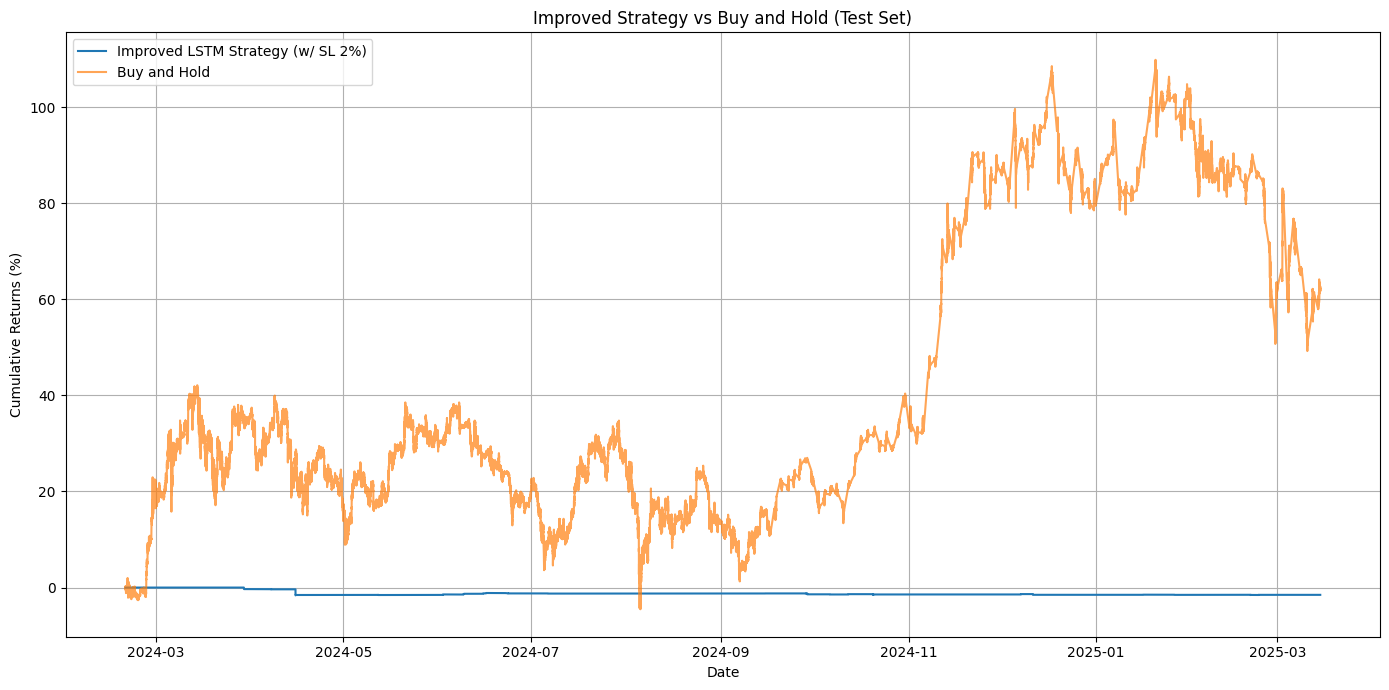

In [60]:
# =========================================
# Cell 28: Plot Backtest Results
# =========================================
plt.figure(figsize=(14, 7))
plt.plot(test_dates, strategy_cumulative_returns * 100, label=f'Improved LSTM Strategy (w/ SL {stop_loss_percentage*100:.0f}%)')
plt.plot(test_dates, buy_hold_returns * 100, label='Buy and Hold', alpha=0.7)
plt.title('Improved Strategy vs Buy and Hold (Test Set)')
plt.xlabel('Date'); plt.ylabel('Cumulative Returns (%)')
plt.legend(); plt.grid(True); plt.tight_layout()
perf_plot_filename = 'strategy_performance_improved.png'
plt.savefig(perf_plot_filename)
print(f"\nStrategy performance plot saved to {perf_plot_filename}")
plt.show()

In [61]:
# =========================================
# Cell 29: Display Backtest Statistics
# =========================================
strategy_final_return = strategy_cumulative_returns[-1] * 100 if len(strategy_cumulative_returns) > 0 else 0
buyhold_final_return = buy_hold_returns[-1] * 100 if len(buy_hold_returns) > 0 else 0

print("\n--- Improved Trading Strategy Results ---")
if len(test_dates) > 0:
    print(f"Test Period Start Date: {test_dates[0]}")
    print(f"Test Period End Date: {test_dates[-1]}")
else: print("Test Period: Empty")
print(f"\nLSTM Strategy Final Return: {strategy_final_return:.2f}% (Using SL-modified signals)")
print(f"Buy and Hold Final Return:  {buyhold_final_return:.2f}%")

# Signal Distribution (Based on SL-modified signals)
num_buy = np.sum(test_positions_with_sl == 1)
num_sell = np.sum(test_positions_with_sl == -1)
num_neutral = np.sum(test_positions_with_sl == 0)
total_signals = len(test_positions_with_sl)

print("\nSignal Distribution (After Stop Loss Application):")
if total_signals > 0:
    print(f" - Total Time Long:    {num_buy} ({num_buy/total_signals*100:.1f}%)")
    print(f" - Total Time Short:   {num_sell} ({num_sell/total_signals*100:.1f}%)")
    print(f" - Total Time Neutral: {num_neutral} ({num_neutral/total_signals*100:.1f}%)")
else: print("No signals generated.")
print("--------------------------------")


--- Improved Trading Strategy Results ---
Test Period Start Date: 2024-02-20 01:31:00
Test Period End Date: 2025-03-15 00:00:00

LSTM Strategy Final Return: -1.51% (Using SL-modified signals)
Buy and Hold Final Return:  61.84%

Signal Distribution (After Stop Loss Application):
 - Total Time Long:    0 (0.0%)
 - Total Time Short:   487 (0.1%)
 - Total Time Neutral: 399503 (99.9%)
--------------------------------


In [62]:
# =========================================
# Cell 30: Simple Trading Guide (Updated)
# =========================================
print("\n--- Simple Bitcoin Trading Strategy Guide (Improved Model) ---")
print(f"1. Model looks back at the previous {time_steps} data points.")
print(f"2. Uses {len(feature_columns)} features including technical indicators (RSI, BB, Stoch, ATR, Volume...) and multi-timeframe metrics.")
print(f"3. Model Architecture: Bidirectional LSTM with Attention.")
print(f"4. Training included Validation Set, Early Stopping, LR Scheduling, Grad Clipping, optional SMOTE balancing.")
print(f"5. Signal interpretation uses DYNAMIC thresholds based on volatility (ATR):")
print(f"   - Base Thresholds: Buy > ~0.55, Sell < ~0.45 (adjusted by volatility)")
print(f"6. Backtest simulation included a {stop_loss_percentage*100:.0f}% stop loss.")
print(f"7. Best Model's Test Accuracy: {test_accuracy_percentage:.2f}%") # From Cell 21
print("\nDisclaimer: This is an educational model. Past performance is not indicative of future results. Trading involves significant risk.")
print("-----------------------------------------")


--- Simple Bitcoin Trading Strategy Guide (Improved Model) ---
1. Model looks back at the previous 10 data points.
2. Uses 29 features including technical indicators (RSI, BB, Stoch, ATR, Volume...) and multi-timeframe metrics.
3. Model Architecture: Bidirectional LSTM with Attention.
4. Training included Validation Set, Early Stopping, LR Scheduling, Grad Clipping, optional SMOTE balancing.
5. Signal interpretation uses DYNAMIC thresholds based on volatility (ATR):
   - Base Thresholds: Buy > ~0.55, Sell < ~0.45 (adjusted by volatility)
6. Backtest simulation included a 2% stop loss.
7. Best Model's Test Accuracy: 52.51%

Disclaimer: This is an educational model. Past performance is not indicative of future results. Trading involves significant risk.
-----------------------------------------


In [63]:
# =========================================
# Cell 31: Prediction Function for New Data (Unchanged conceptually)
# =========================================
# This function uses the currently loaded model (which should be the best one)
# and the scaler fitted during training.

def predict_trade_signal(new_data_df, model, scaler, feature_columns, time_steps, device, threshold_buy=0.6, threshold_sell=0.4, use_dynamic=True, vol_col='ATR', vol_factor=0.1):
    """Predicts trading signals on new unseen data."""
    print("\n--- Predicting on New Data ---")
    if len(new_data_df) < time_steps:
        print(f"Error: Need at least {time_steps} rows, got {len(new_data_df)}."); return None, None
    missing_cols = [col for col in feature_columns if col not in new_data_df.columns]
    if missing_cols: print(f"Error: Missing columns: {missing_cols}"); return None, None

    X_new = new_data_df[feature_columns].iloc[-time_steps:].values
    if np.isnan(X_new).any(): print(f"Error: NaNs in last {time_steps} rows."); return None, None

    X_new_scaled = scaler.transform(X_new) # Use transform
    X_new_seq = np.array([X_new_scaled]) # Shape: (1, time_steps, n_features)
    X_new_tensor = torch.FloatTensor(X_new_seq).to(device)

    model.eval()
    with torch.no_grad():
        probability = model(X_new_tensor).squeeze().cpu().item()

    # Determine signal (dynamic or fixed)
    if use_dynamic:
        if vol_col in new_data_df.columns:
            # Get the *last* volatility value from the input data
            last_volatility = new_data_df[vol_col].iloc[-1]
            last_volatility = np.nan_to_num(last_volatility, nan=0.0) # Handle potential NaN
            dynamic_buy = np.clip(threshold_buy + last_volatility * vol_factor, 0.501, 0.95)
            dynamic_sell = np.clip(threshold_sell - last_volatility * vol_factor, 0.05, 0.499)
            print(f"Using dynamic thresholds based on last volatility ({vol_col}={last_volatility:.2f}): Buy > {dynamic_buy:.3f}, Sell < {dynamic_sell:.3f}")
            if probability > dynamic_buy: signal = 1
            elif probability < dynamic_sell: signal = -1
            else: signal = 0
        else:
            print(f"Warning: Volatility column '{vol_col}' not found for dynamic threshold. Using fixed.")
            if probability > threshold_buy: signal = 1
            elif probability < threshold_sell: signal = -1
            else: signal = 0
    else: # Use fixed thresholds
        print(f"Using fixed thresholds: Buy > {threshold_buy}, Sell < {threshold_sell}")
        if probability > threshold_buy: signal = 1
        elif probability < threshold_sell: signal = -1
        else: signal = 0

    print(f"Prediction for next timestep: Probability={probability:.4f}, Signal={signal}")
    print("-----------------------------")
    return probability, signal

print("predict_trade_signal function defined.")


predict_trade_signal function defined.


In [64]:
# =========================================
# Cell 32: Example Usage for New Data Prediction (Conceptual)
# =========================================
# --- This cell demonstrates the workflow - requires real new data and preprocessing ---
print("\n--- Example: Using the model for a new prediction ---")
# 1. Load new data (e.g., latest 100 rows)
# new_data_raw = pd.read_csv('latest_btc_data.csv', index_col='Timestamp', parse_dates=True)
# print(f"Loaded {len(new_data_raw)} new data points.")

# 2. Preprocess EXACTLY as training data (Cells 5, 6, 7)
#    - Convert numeric, fill flow NaNs
#    - Calculate ALL features (Returns, MAs, MACD, RSI, BB, Stoch, ATR, Volume etc.)
#    - Handle ALL resulting NaNs (replace inf, ffill, bfill, fillna(0))
#    print("Preprocessing new data...")
#    # --- Add ALL preprocessing steps here ---
#    # new_data_processed = preprocess_function(new_data_raw) # Assume a function encapsulates steps

# 3. Make prediction using the last `time_steps` rows of PREPROCESSED data
#    (Using last rows of existing 'df' for demo purposes only)
if len(df) >= time_steps:
    demo_new_data = df.iloc[-time_steps:].copy() # Use last processed rows for demo
    print(f"Using last {time_steps} rows of processed data for demo prediction.")

    probability, signal = predict_trade_signal(
        new_data_df=demo_new_data, # Needs to be fully preprocessed df slice
        model=model,           # Uses the loaded best model
        scaler=scaler,         # Uses the scaler fitted on training data
        feature_columns=feature_columns,
        time_steps=time_steps,
        device=device,
        threshold_buy=0.55,    # Base threshold for dynamic
        threshold_sell=0.45,   # Base threshold for dynamic
        use_dynamic=True,     # Enable dynamic thresholds
        vol_col='ATR'         # Use ATR for volatility adjustment
    )

    # 4. Interpret signal
    if signal is not None:
        print("\nPredicted Trading Action for the NEXT time step:")
        if signal == 1: print("  >> BUY")
        elif signal == -1: print("  >> SELL")
        else: print("  >> HOLD / NEUTRAL")
    else: print("\nPrediction failed.")
else:
    print("\nNot enough data in 'df' to run prediction demo.")

print("----------------------------------------------------")
print("\nImproved LSTM model notebook execution complete!")


--- Example: Using the model for a new prediction ---
Using last 10 rows of processed data for demo prediction.

--- Predicting on New Data ---
Using dynamic thresholds based on last volatility (ATR=27.36): Buy > 0.950, Sell < 0.050
Prediction for next timestep: Probability=0.4316, Signal=0
-----------------------------

Predicted Trading Action for the NEXT time step:
  >> HOLD / NEUTRAL
----------------------------------------------------

Improved LSTM model notebook execution complete!
